In [3]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-08-03 16:27:31


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf

from   invisible_cities.evm.ic_containers           import S12Params 
from   invisible_cities.evm.ic_containers          import CalibVectors
from   invisible_cities.evm.ic_containers          import DeconvParams
from   invisible_cities.evm.ic_containers          import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
from   invisible_cities.types.ic_types import Counter
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.icaro.pmaps_mpl import plot_s2si_map

In [6]:
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.mpl_functions     import circles

In [7]:
import invisible_cities.evm.event_model as evm

In [8]:
from invisible_cities.evm.pmaps import S12
from invisible_cities.evm.pmaps import S1
from invisible_cities.evm.pmaps import S2
from invisible_cities.evm.pmaps import S2Si

In [9]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound

In [10]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [11]:
run_number = -4446
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [12]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [13]:
RWF_file = os.path.join(os.environ['IC_DATA'], 'MC_PreProd_July_2017',
                        'electrons.2615keV_RWF.z250mm.10evts.h5')
print('RWF file = {}'.format(RWF_file))

RWF file = /Users/jjgomezcadenas/Projects/ICDATA/MC_PreProd_July_2017/electrons.2615keV_RWF.z250mm.10evts.h5


In [14]:
h5rwf = tb.open_file(RWF_file,'r')

In [15]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
NEVT, pmtrwf, sipmrwf, _ = tbl.get_rwf_vectors(h5rwf)
sp = tbl.get_sensor_params_from_vectors(pmtrwf, sipmrwf)
print(sp)

####################
SensorParams
####################
npmt: 12
pmtwl: 48000
nsipm: 1792
sipmwl: 1200



### Reconstruction Parameters

In [16]:
calib_vectors = CalibVectors(channel_id = DataPMT.ChannelID.values,
                             coeff_blr = abs(DataPMT.coeff_blr   .values),
                             coeff_c = abs(DataPMT.coeff_c   .values),
                             adc_to_pes = DataPMT.adc_to_pes.values,
                             adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                             pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist())


deconv_params = DeconvParams(n_baseline = 45000,
                              thr_trigger = 5)

s1par = S12Params(time = minmax(min    = 99 * units.mus,
                           max    = 101 * units.mus),
                           stride = 4,
                           length = minmax(min = 6, max = 30),  #150 ns -- 500 ns
                           rebin_stride  = 1)

s2par = S12Params(time = minmax(min    = 101 * units.mus,
                           max    = 1199 * units.mus),
                           stride = 40,
                           length = minmax(min = 120, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

thresholds = ThresholdParams(thr_s1=3.5 * units.pes,
                      thr_s2=1.0 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=1.5*units.pes,
                      thr_SIPM=15*units.pes)



In [17]:
event = 0

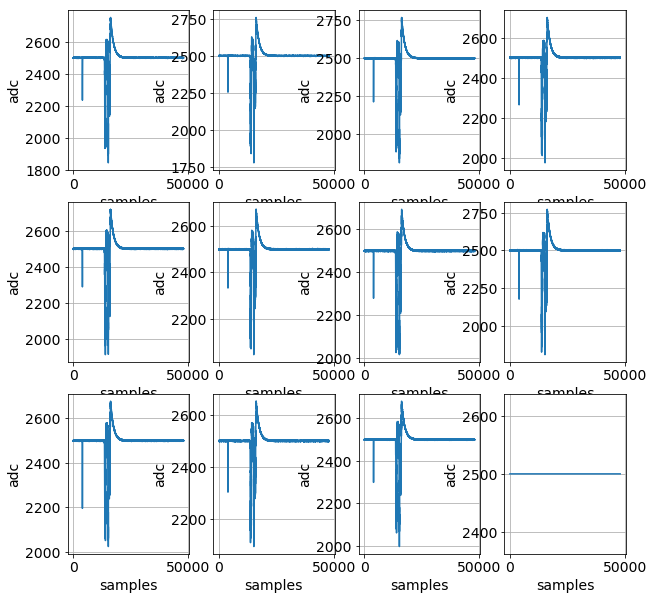

In [18]:
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))

#### Deconvolution

In [19]:
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)

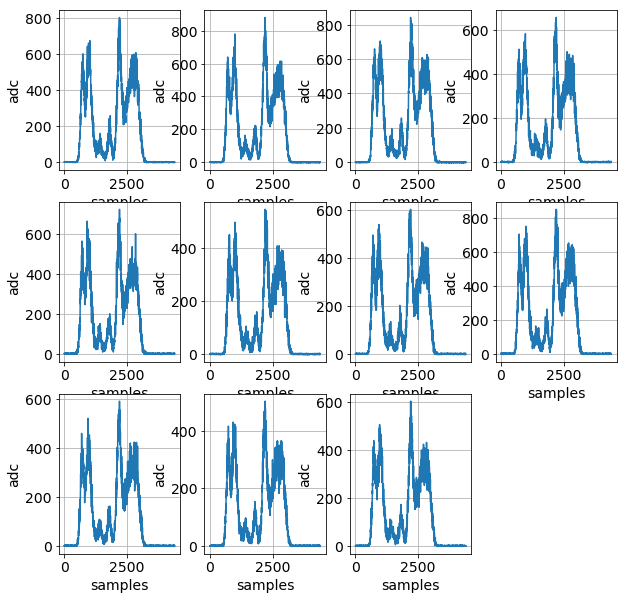

In [20]:
mpl.plot_pmt_waveforms(CWF, zoom=True, window_size=2200, figsize=(10,10))

#### csum

In [21]:
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)

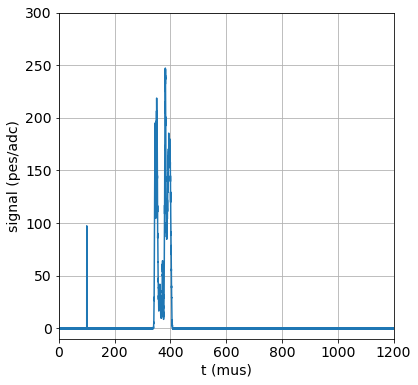

In [22]:
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    -10,
                        signal_max =  300,
                        figsize=(6,6))

#### S1 and S2

In [23]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)

In [24]:
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())


In [25]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 20 width =      0.5 mus , energy =    736.2 pes
        height =     97.4 pes tmin-tmax = minmax(min=100.05, max=100.525) mus  

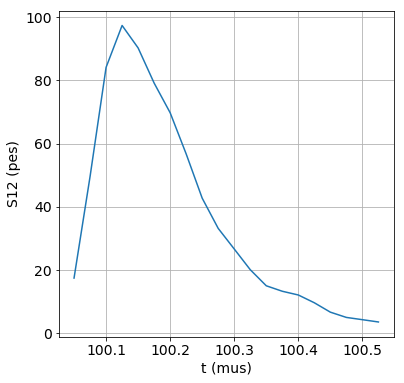

In [26]:
plot_s12(s1)

In [27]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 69 width =     67.6 mus , energy = 251261.5 pes
        height =   9471.0 pes tmin-tmax = minmax(min=339.6, max=407.21250000000003) mus  

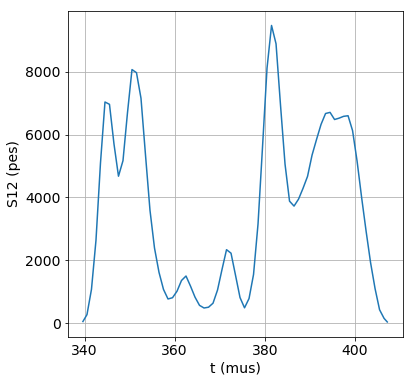

In [28]:
plot_s12(s2)

#### S2Si

In [29]:
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)

In [30]:
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)

In [31]:
s2si.number_of_peaks

1

In [73]:

def plot_s2si_map(s2si, run_number=0, cmap='binary'):
        """Plot a map of the energies of S2Si objects."""

        DataSensor = load_db.DataSiPM(run_number)
        radius = 2
        xs = DataSensor.X.values
        ys = DataSensor.Y.values
        r = np.ones(len(xs)) * radius
        col = np.zeros(len(xs))
        for peak_no in range(s2si.number_of_peaks):
               for sipm_no in s2si.sipms_in_peak(peak_no):
                    col[sipm_no] += s2si.sipm_total_energy(peak_no, sipm_no)

        hist, edges = np.histogram(col)
        print(hist)
        print(edges)
        plt.figure(figsize=(8, 8))
        plt.subplot(aspect="equal")
        col2 = [c + 300 if 150 < c < 250 else c for c in col]
        circles(xs, ys, r, c=col2, alpha=0.5, ec="none", cmap=cmap)
        plt.colorbar()

        plt.xlim(-198, 198)
        plt.ylim(-198, 198)


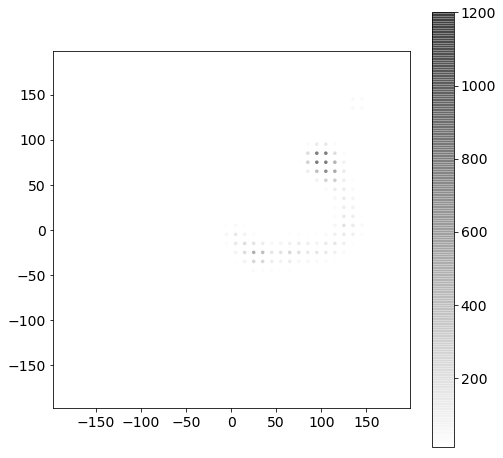

In [43]:
plot_s2si_map(s2si, vmin=10, vmax=1200, run_number=-4446, cmap='binary')

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 19 width =      0.5 mus , energy =    641.5 pes
        height =     87.0 pes tmin-tmax = minmax(min=100.05, max=100.5) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 88 width =     86.5 mus , energy = 275342.9 pes
        height =  11874.8 pes tmin-tmax = minmax(min=259.8, max=346.25) mus  

[1767   10    4    2    3    2    1    2    0    1]
[    0.           260.53186226   521.06372452   781.59558678  1042.12744904
  1302.6593113   1563.19117356  1823.72303582  2084.25489808  2344.78676034
  2605.3186226 ]


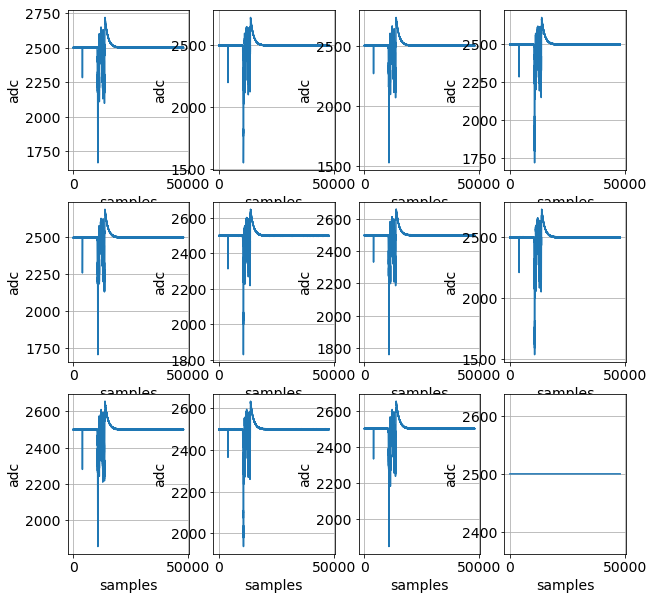

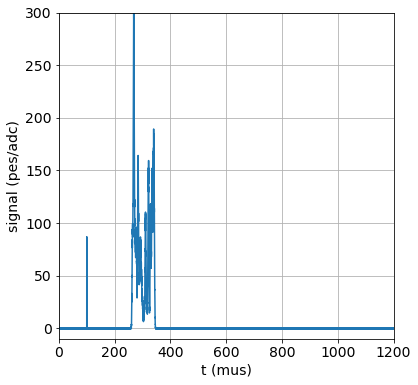

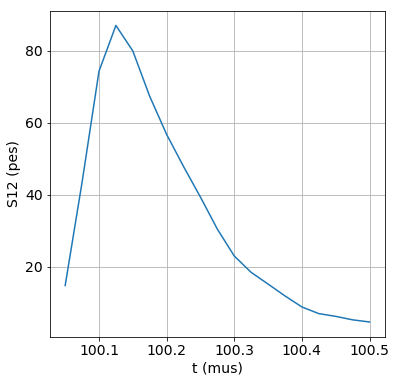

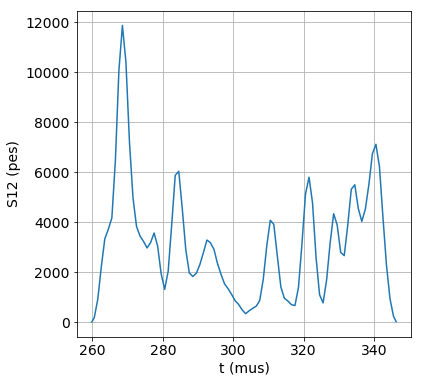

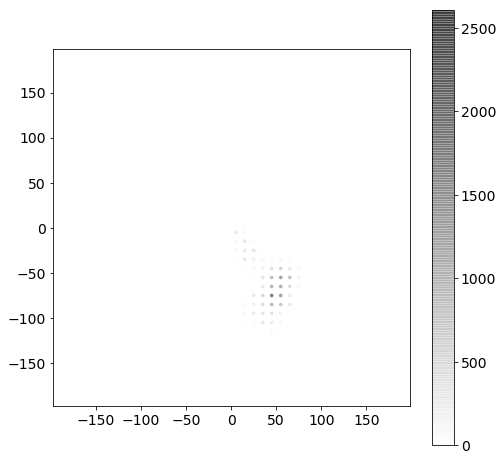

In [76]:
event = 1
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    -10,
                        signal_max =  300,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 20 width =      0.5 mus , energy =    858.2 pes
        height =    113.3 pes tmin-tmax = minmax(min=100.05, max=100.525) mus  

S2 (number of peaks = 3)
peak number = 0: Peak(samples = 15 width =     13.6 mus , energy =  18762.2 pes
        height =   3128.4 pes tmin-tmax = minmax(min=342.5375, max=356.15000000000003) mus  
peak number = 1: Peak(samples = 28 width =     26.4 mus , energy =  13176.5 pes
        height =   1175.3 pes tmin-tmax = minmax(min=359.925, max=386.27500000000003) mus  
peak number = 2: Peak(samples = 131 width =    129.6 mus , energy = 204135.7 pes
        height =   5728.3 pes tmin-tmax = minmax(min=390.725, max=520.3625) mus  

[1722   30   15   12    6    4    1    0    0    2]
[   0.           98.51606504  197.03213008  295.54819513  394.06426017
  492.58032521  591.09639025  689.61245529  788.12852033  886.64458538
  985.16065042]


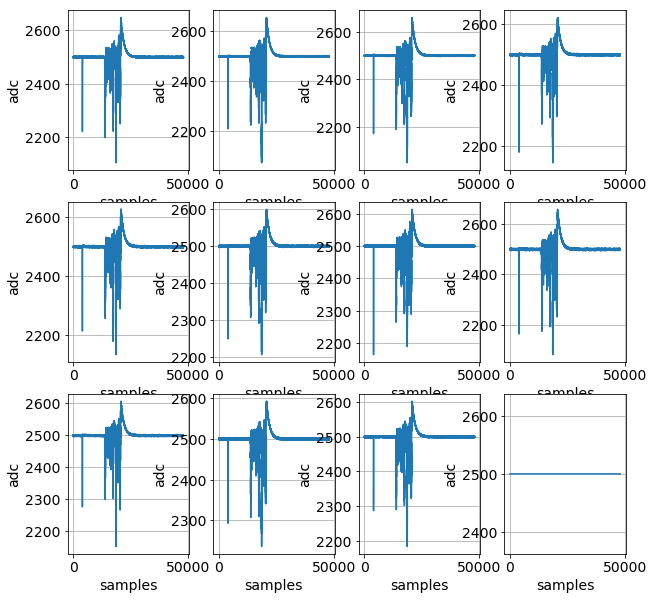

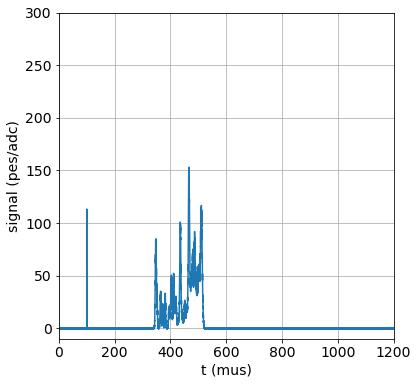

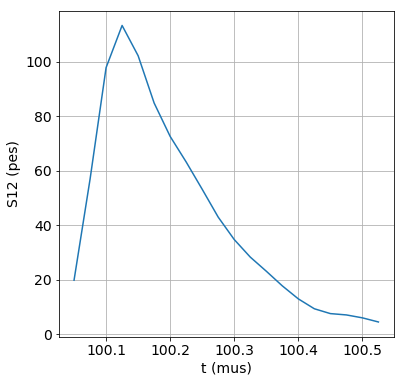

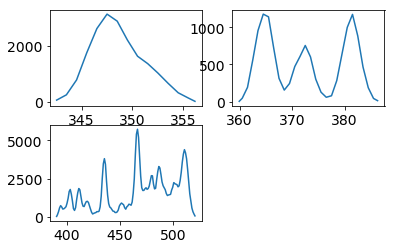

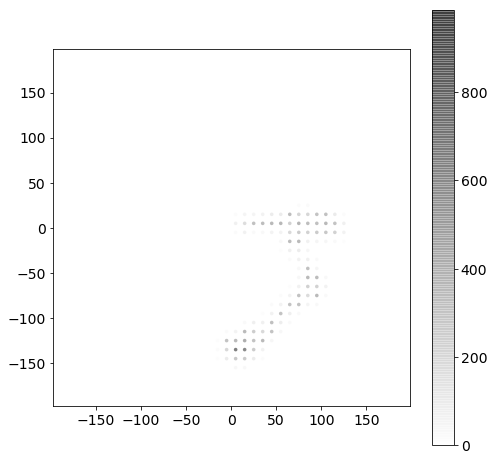

In [77]:
event = 2
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    -10,
                        signal_max =  300,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 19 width =      0.5 mus , energy =    788.6 pes
        height =    101.5 pes tmin-tmax = minmax(min=100.05, max=100.5) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 95 width =     93.5 mus , energy = 243529.2 pes
        height =  10357.2 pes tmin-tmax = minmax(min=337.9375, max=431.4125) mus  

[1712   45   19    5    6    3    0    0    1    1]
[    0.           108.83033542   217.66067083   326.49100625   435.32134167
   544.15167709   652.9820125    761.81234792   870.64268334   979.47301876
  1088.30335417]


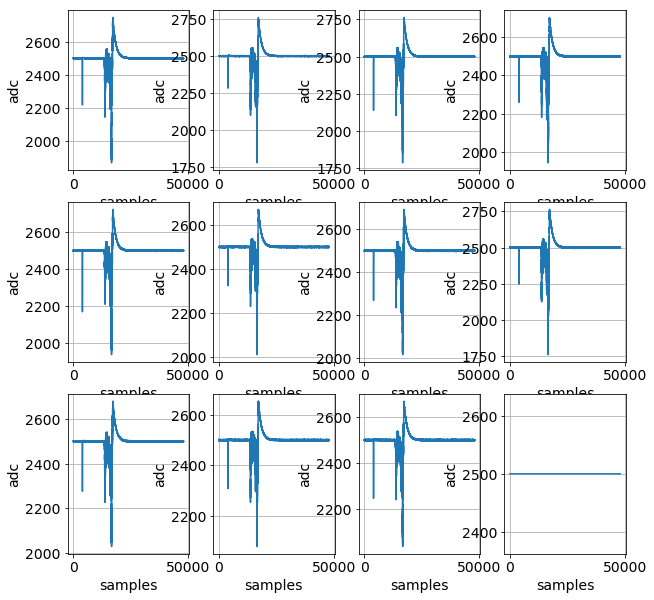

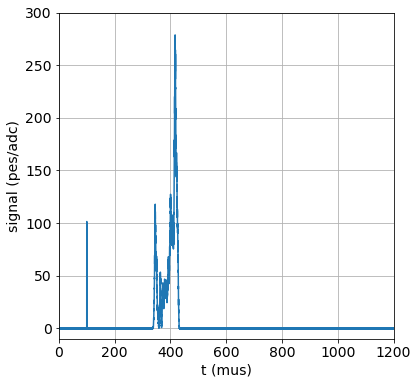

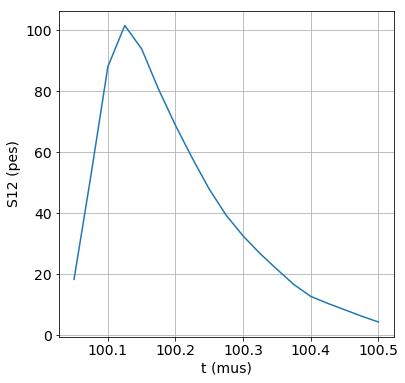

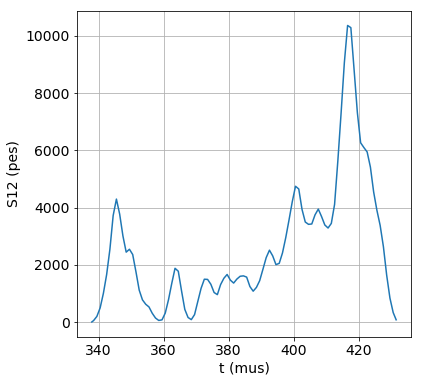

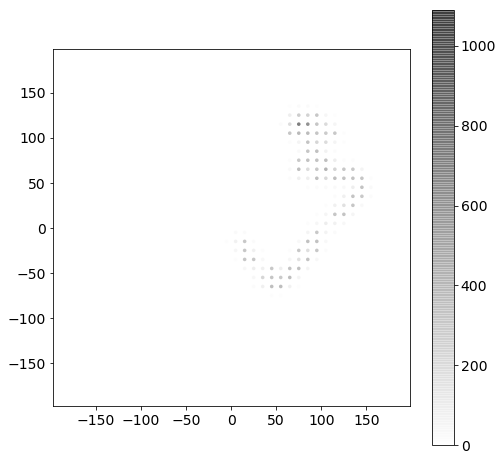

In [78]:
event = 3
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    -10,
                        signal_max =  300,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 20 width =      0.5 mus , energy =    693.3 pes
        height =     94.4 pes tmin-tmax = minmax(min=100.05, max=100.525) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 61 width =     59.9 mus , energy = 239373.7 pes
        height =  17331.0 pes tmin-tmax = minmax(min=345.6375, max=405.4875) mus  

[1723   35   19    6    1    3    1    1    0    3]
[    0.           117.67645056   235.35290111   353.02935167   470.70580222
   588.38225278   706.05870334   823.73515389   941.41160445  1059.08805501
  1176.76450556]


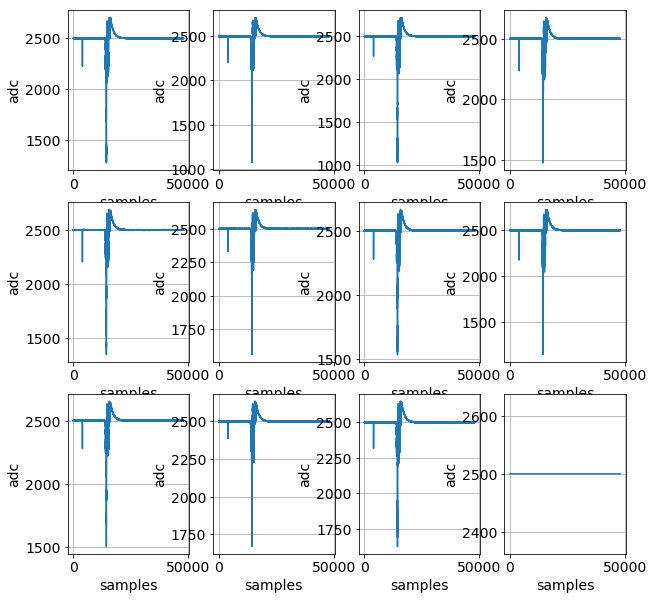

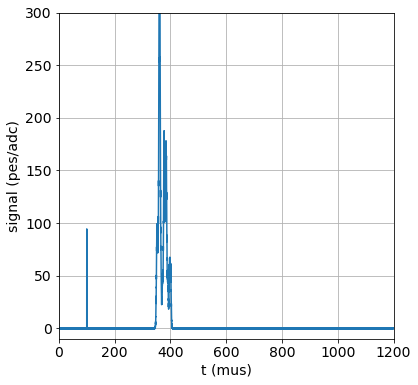

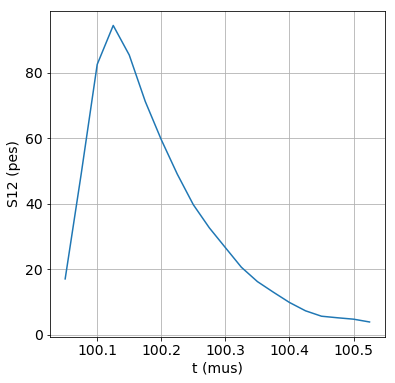

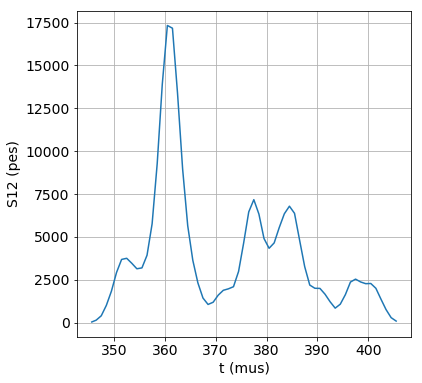

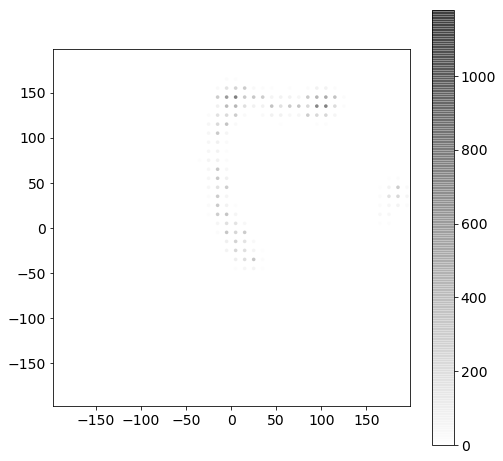

In [79]:
event = 4
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    -10,
                        signal_max =  300,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 17 width =      0.4 mus , energy =    393.3 pes
        height =     52.4 pes tmin-tmax = minmax(min=100.05, max=100.45) mus  

S2 (number of peaks = 3)
peak number = 0: Peak(samples = 56 width =     54.7 mus , energy = 143748.5 pes
        height =   9011.4 pes tmin-tmax = minmax(min=263.7375, max=318.425) mus  
peak number = 1: Peak(samples = 10 width =      8.2 mus , energy =   4726.1 pes
        height =   1145.9 pes tmin-tmax = minmax(min=320.83750000000003, max=329.0125) mus  
peak number = 2: Peak(samples = 26 width =     24.6 mus , energy =  27673.6 pes
        height =   3131.9 pes tmin-tmax = minmax(min=332.5, max=357.1125) mus  

[1759   16    5    7    0    1    1    2    0    1]
[    0.           150.9131638    301.8263276    452.7394914    603.6526552
   754.565819     905.4789828   1056.3921466   1207.30531041  1358.21847421
  1509.13163801]


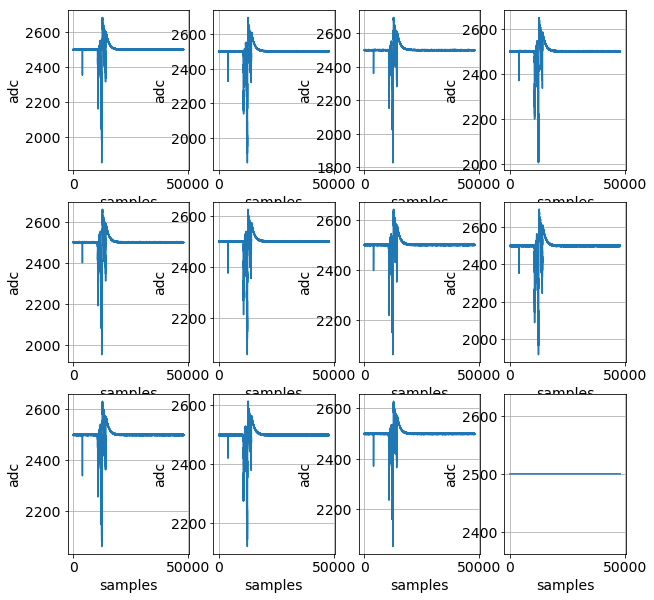

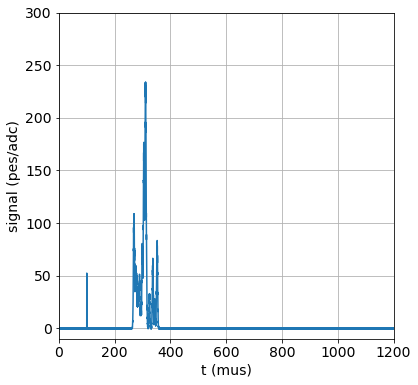

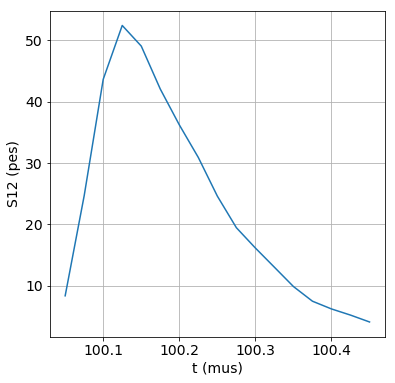

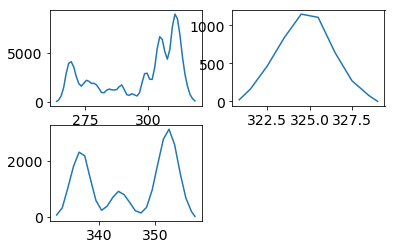

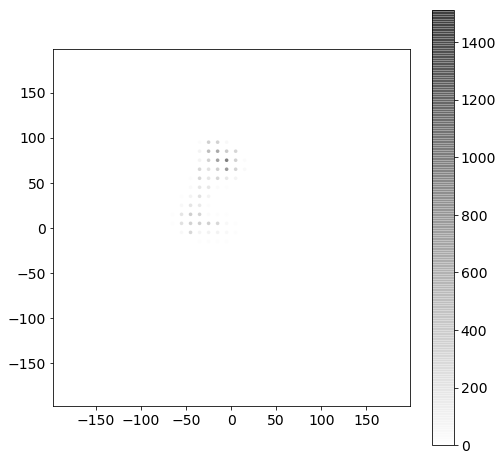

In [80]:
event = 5
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    -10,
                        signal_max =  300,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 18 width =      0.4 mus , energy =    520.3 pes
        height =     68.2 pes tmin-tmax = minmax(min=100.05, max=100.47500000000001) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 86 width =     84.3 mus , energy = 193440.6 pes
        height =   6543.8 pes tmin-tmax = minmax(min=275.8, max=360.15000000000003) mus  

[1729   24   21    7    5    0    3    1    1    1]
[   0.           98.74130392  197.48260783  296.22391175  394.96521566
  493.70651958  592.44782349  691.18912741  789.93043133  888.67173524
  987.41303916]


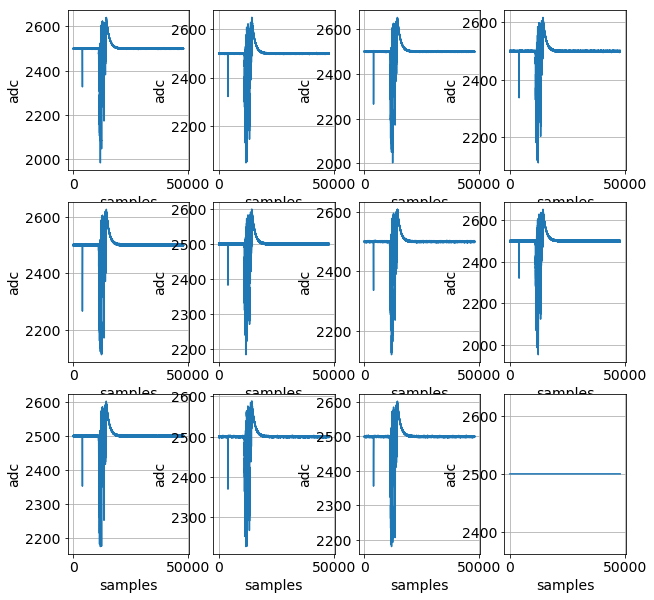

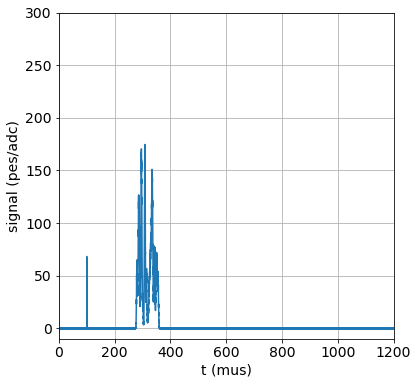

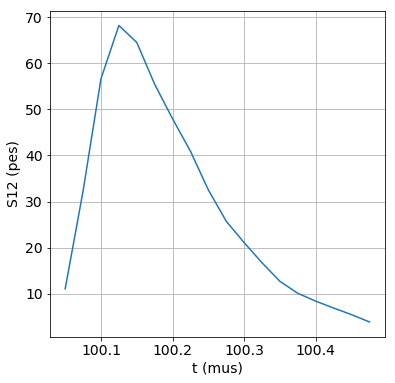

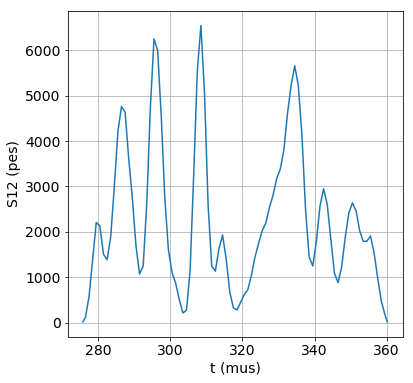

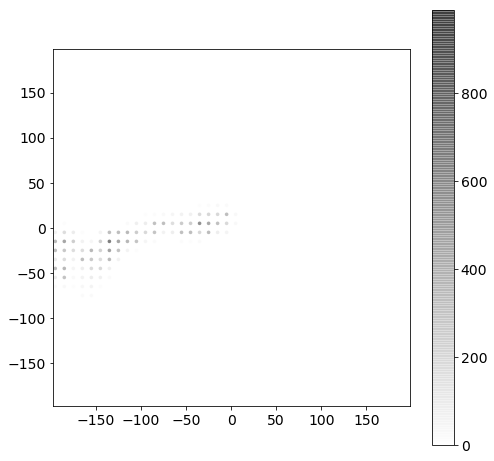

In [81]:
event = 6
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    -10,
                        signal_max =  300,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 19 width =      0.5 mus , energy =    647.0 pes
        height =     86.9 pes tmin-tmax = minmax(min=100.05, max=100.5) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 59 width =     57.6 mus , energy = 227643.5 pes
        height =  11396.1 pes tmin-tmax = minmax(min=339.77500000000003, max=397.3625) mus  
peak number = 1: Peak(samples = 11 width =      9.9 mus , energy =  10189.0 pes
        height =   2085.1 pes tmin-tmax = minmax(min=477.5375, max=487.425) mus  

[1760   11    6    5    2    0    3    1    2    2]
[    0.           164.13763006   328.27526012   492.41289018   656.55052024
   820.6881503    984.82578036  1148.96341042  1313.10104048  1477.23867054
  1641.3763006 ]


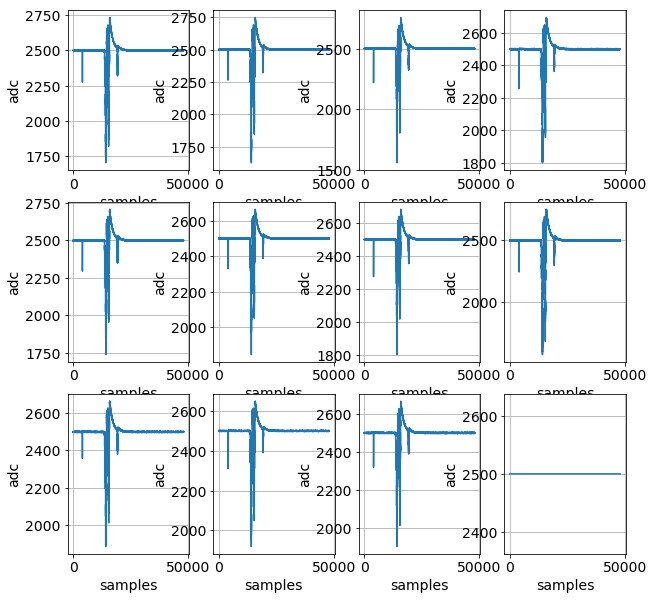

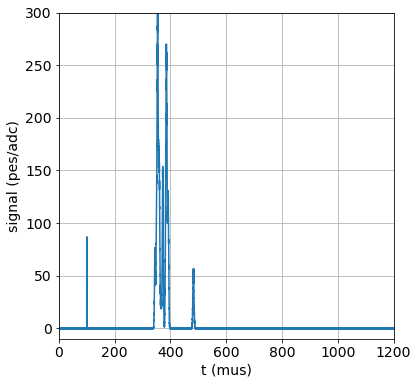

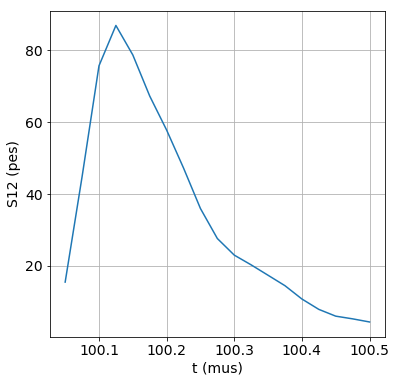

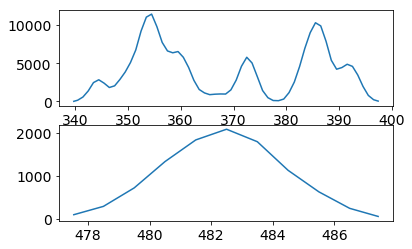

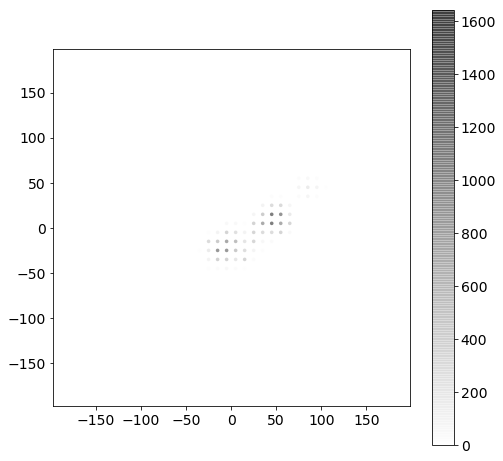

In [82]:
event = 7
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    -10,
                        signal_max =  300,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 19 width =      0.5 mus , energy =    680.7 pes
        height =     91.5 pes tmin-tmax = minmax(min=100.05, max=100.5) mus  

S2 (number of peaks = 4)
peak number = 0: Peak(samples = 8 width =      6.2 mus , energy =   2762.9 pes
        height =    805.4 pes tmin-tmax = minmax(min=248.875, max=255.0625) mus  
peak number = 1: Peak(samples = 60 width =     58.6 mus , energy = 259074.7 pes
        height =  13006.2 pes tmin-tmax = minmax(min=261.675, max=320.2375) mus  
peak number = 2: Peak(samples = 10 width =      8.3 mus , energy =   5960.6 pes
        height =   1487.9 pes tmin-tmax = minmax(min=324.83750000000003, max=333.1375) mus  
peak number = 3: Peak(samples = 10 width =      8.4 mus , energy =   6257.0 pes
        height =   1533.5 pes tmin-tmax = minmax(min=337.9375, max=346.33750000000003) mus  

[1757   22    6    3    2    1    0    0    0    1]
[    0.           257.95971879   515.91943758   773.87915638  1031.83

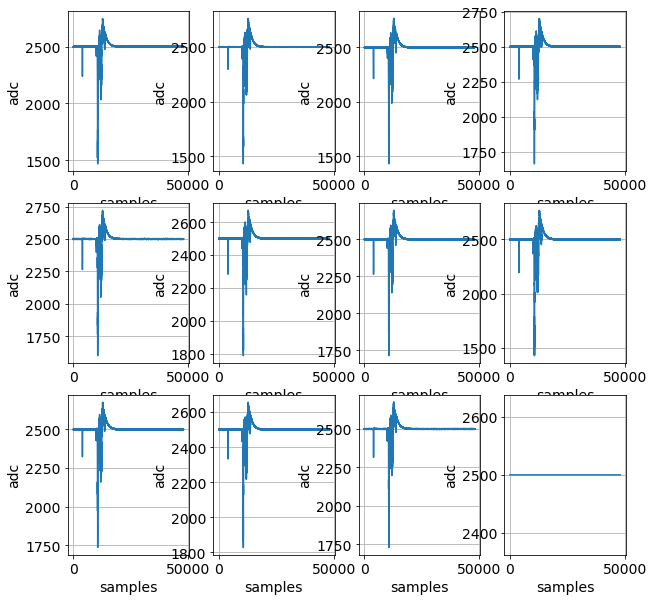

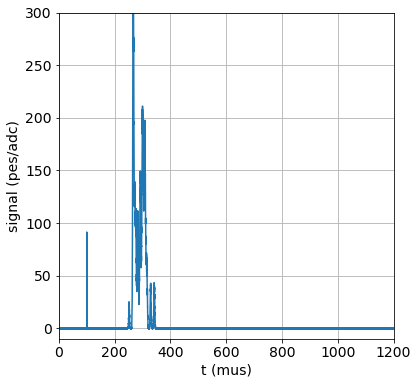

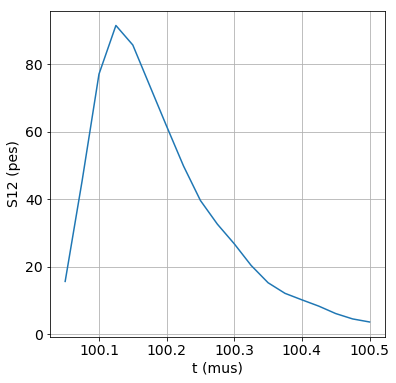

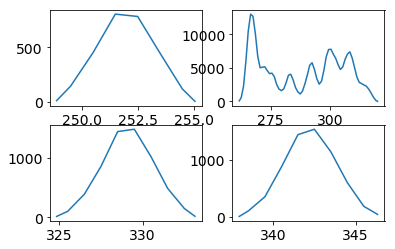

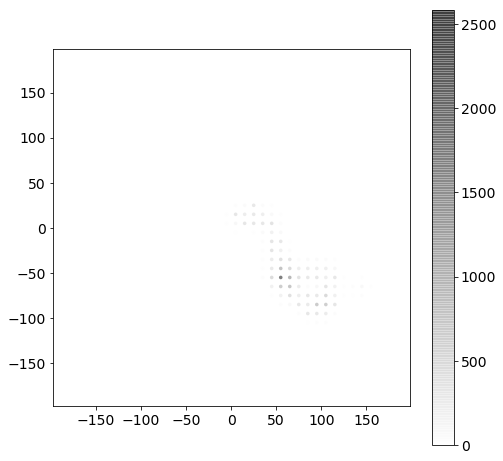

In [83]:
event = 8
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    -10,
                        signal_max =  300,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 18 width =      0.4 mus , energy =    505.6 pes
        height =     66.7 pes tmin-tmax = minmax(min=100.05, max=100.47500000000001) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 105 width =    103.6 mus , energy = 211577.5 pes
        height =  12578.7 pes tmin-tmax = minmax(min=253.7375, max=357.35) mus  

[1754   18   10    4    2    1    2    0    0    1]
[    0.           167.02929776   334.05859551   501.08789327   668.11719102
   835.14648878  1002.17578653  1169.20508429  1336.23438204  1503.2636798
  1670.29297755]


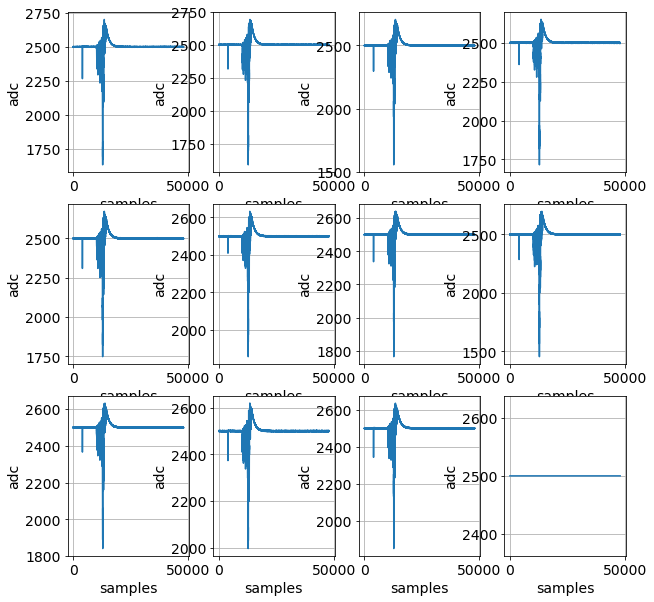

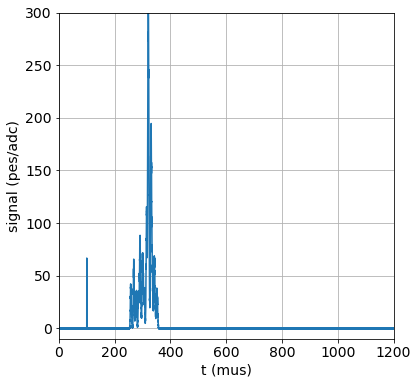

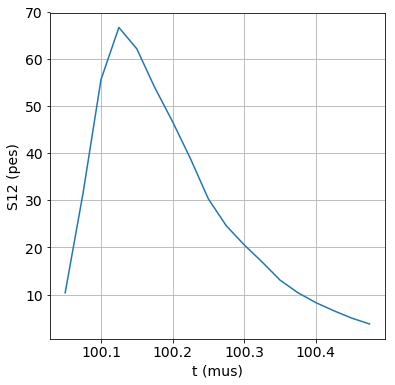

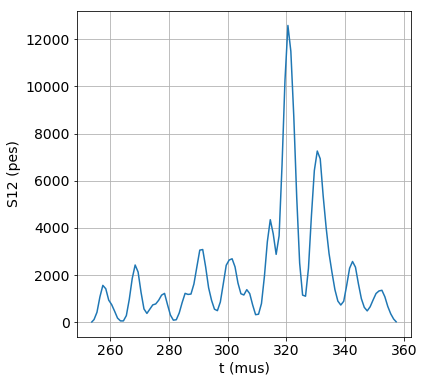

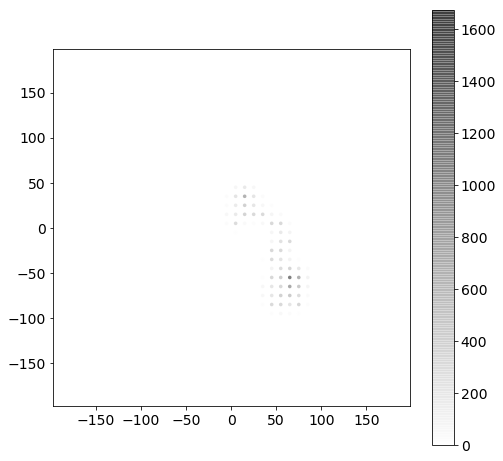

In [84]:
event = 9
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    -10,
                        signal_max =  300,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
plot_s2si_map(s2si, run_number=-4446)